In [1]:
import open3d as o3d
import torch
import numpy as np
from path_planning import get_floor_grid, rotation_matrix_from_vectors
# set seed for open3d
o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Debug)

# import plt
import matplotlib.pyplot as plt


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:

# # load point cloud
# pcd = o3d.io.read_point_cloud("./data/downsampled_pcd.ply")
# # o3d.visualization.draw_geometries([pcd])

# # Remove the ground plane
# plane_model, inliers = pcd.segment_plane(distance_threshold=0.1, ransac_n=3, num_iterations=1000)
# inlier_cloud = pcd.select_by_index(inliers)
# outlier_cloud = pcd.select_by_index(inliers, invert=True)
# o3d.visualization.draw_geometries([inlier_cloud])

In [3]:
point_cloud_path = "data/downsampled_pcd.ply"
seg_masks_path = "data/filtered_3d_masks.pth"
point_cloud: o3d.geometry.PointCloud = o3d.io.read_point_cloud(point_cloud_path)
seg_mask = torch.load(seg_masks_path, map_location=torch.device('cuda'))

# visualize the point cloud
o3d.visualization.draw_geometries([point_cloud])

[Open3D DEBUG] Format auto File data/downsampled_pcd.ply
[Open3D DEBUG] Read geometry::PointCloud: 288792 vertices.
[Open3D DEBUG] [Visualizer] Creating window.
[Open3D DEBUG] GLFW init.
[Open3D DEBUG] Add geometry and update bounding box to [(-3.4075, -1.8550, -3.7353) - (8.1412, 0.3950, 3.6750)]
[Open3D DEBUG] Global colormap init.
[Open3D DEBUG] [Visualizer] Destroying window.
[Open3D DEBUG] GLFW destruct.


[Open3D DEBUG] RANSAC | Inliers: 107564, Fitness: 3.724618e-01, RMSE: 3.400521e-02, Iteration: 353


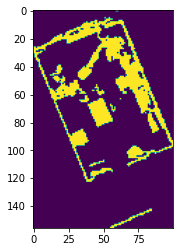

In [4]:
#segment out the planes

plane_model, inliers = point_cloud.segment_plane(distance_threshold=0.1,
                                            ransac_n=3,
                                            num_iterations=1000)




norm_z = plane_model[0:3]
#randomly sample 10 points from the point cloud
# and align the norm z so that the projected mean of the ten sampled points are positive
samples = np.random.randint(0,len(point_cloud.colors)-1, 10)
coordinates = np.asarray(point_cloud.points)
samples = coordinates[samples]
samples = np.dot(samples,norm_z)
if np.sum(samples) < 0:
    norm_z = norm_z*(-1.0)

original_z = [0,0,1]
assert len(norm_z) == 3
rotate = rotation_matrix_from_vectors(original_z,norm_z)
transform_matrix = np.eye(4,dtype=float)
transform_matrix[0:3,0:3] = rotate
point_cloud.transform(transform_matrix)

color_array = np.asarray(point_cloud.colors)
coordinates = np.asarray(point_cloud.points)
z_mean = coordinates[inliers][:,2].mean()

grid, bb, voxel_size = get_floor_grid(coordinates,z_mean,100 )


#color_array[inliers] = [1.0,0.0,0.0]

# samples = np.random.randint(0, len(inliers) - 1, 60)
#
# pdb.set_trace()
# print(np.asarray(point_cloud.points)[np.array(inliers)[samples]])
plt.imshow(grid==1)
plt.show()


In [5]:
zeros_indices = np.argwhere(grid==0)
print(zeros_indices)
grid.max(), grid.min()

[[  0   0]
 [  0   1]
 [  0   2]
 ...
 [155  97]
 [155  98]
 [155  99]]


(1.0, 0.0)

In [6]:
# randomly select a start and end point
# start_point = tuple(zeros_indices[np.random.randint(0, len(zeros_indices))])
# end_point = tuple(zeros_indices[np.random.randint(0, len(zeros_indices))])
start_point = (23, 40)
end_point = (90, 90)

grid_free = grid==0
def astar(grid, start_point, end_point):
    """calculate the shortest path from start_point to end_point using A* algorithm

    Args:
        grid (_type_): a 2D numpy array representing the environment, 0 for obstacle, 1 for free space
        start_point (_type_): _description_
        end_point (_type_): _description_

    Returns:
        _type_: a list of points in the shortest path
    """
    def heuristic(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def get_neighbors(point):
        neighbors = []
        for i in range(-1, 2):
            for j in range(-1, 2):
                if i == 0 and j == 0:
                    continue
                x = point[0] + i
                y = point[1] + j
                if x >= 0 and x < grid.shape[0] and y >= 0 and y < grid.shape[1]:
                    neighbors.append((x, y))
        return neighbors

    def get_path(came_from, current):
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.append(start_point)
        return path[::-1]

    open_set = set([start_point])
    came_from = {}
    g_score = {start_point: 0}
    f_score = {start_point: heuristic(start_point, end_point)}

    while open_set:
        current = min(open_set, key=lambda x: f_score[x])
        if current == end_point:
            return get_path(came_from, current)

        open_set.remove(current)
        for neighbor in get_neighbors(current):
            tentative_g_score = g_score[current] + 1
            if grid[neighbor[0], neighbor[1]] == 0:
                continue
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, end_point)
                if neighbor not in open_set:
                    open_set.add(neighbor)

    return None
    

    


path = astar(grid_free, start_point, end_point)
print(path)

[(23, 40), (24, 41), (25, 42), (26, 43), (27, 44), (28, 44), (29, 43), (30, 42), (31, 42), (32, 41), (33, 41), (34, 40), (35, 40), (36, 39), (37, 38), (38, 37), (39, 36), (40, 35), (41, 34), (42, 33), (43, 32), (44, 31), (45, 31), (46, 31), (47, 31), (48, 32), (49, 33), (50, 34), (51, 35), (52, 36), (53, 37), (54, 38), (55, 39), (56, 40), (57, 41), (58, 42), (59, 43), (60, 44), (61, 45), (62, 46), (62, 47), (62, 48), (62, 49), (63, 50), (64, 51), (65, 52), (66, 53), (67, 54), (68, 54), (69, 55), (70, 55), (71, 55), (72, 56), (73, 57), (74, 58), (75, 59), (76, 60), (77, 61), (78, 62), (79, 63), (80, 64), (81, 65), (82, 66), (83, 67), (84, 68), (85, 69), (86, 70), (87, 71), (88, 72), (89, 73), (90, 74), (90, 75), (90, 76), (90, 77), (90, 78), (90, 79), (90, 80), (90, 81), (90, 82), (90, 83), (90, 84), (90, 85), (90, 86), (90, 87), (90, 88), (90, 89), (90, 90)]


(156, 100)


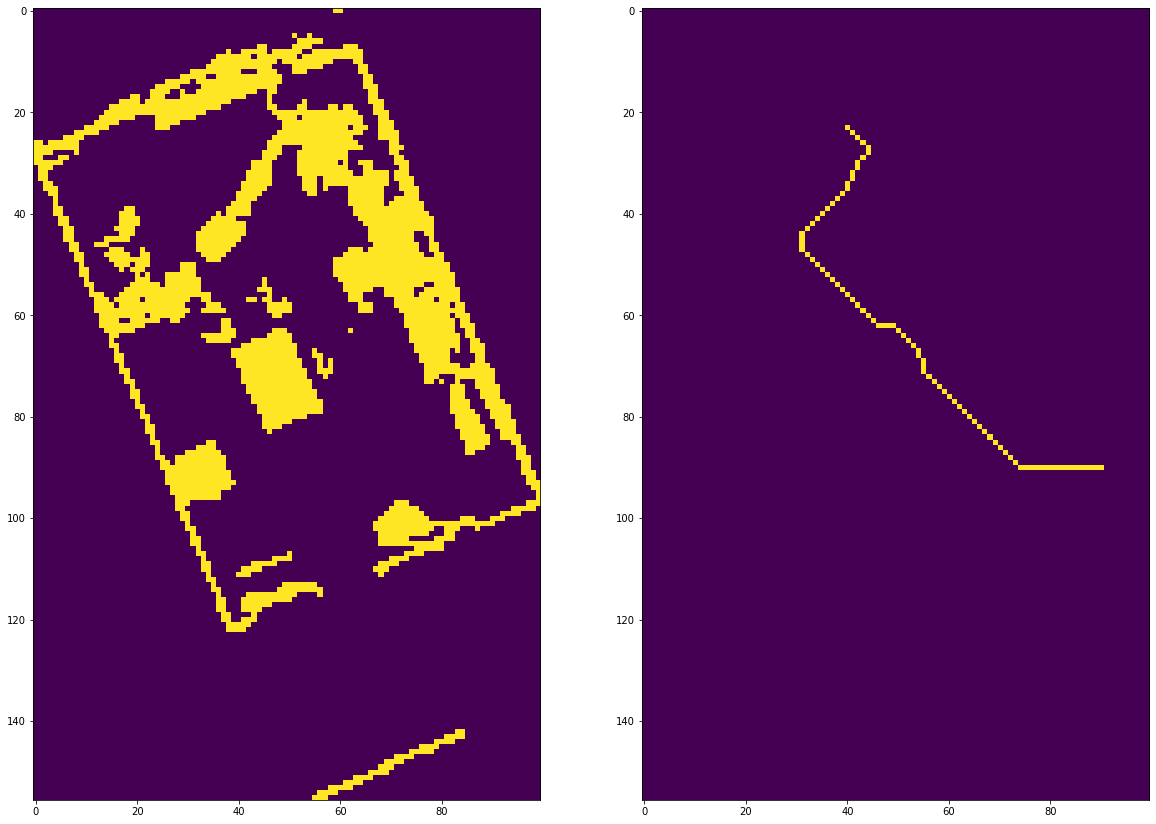

In [7]:
path = np.array(path)

path_grid = np.zeros_like(grid)
path_grid[path[:, 0], path[:, 1]] = 1
print(path_grid.shape)

# start point and end point
start_grid = np.zeros_like(grid)
start_grid[start_point[0], start_point[1]] = 100
end_grid = np.zeros_like(grid)
end_grid[end_point[0], end_point[1]] = 100

# adjust the plot size
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(grid>0)
plt.subplot(1, 2, 2)
plt.imshow(path_grid>0)

In [14]:
# convert path to world coordinates
max_bound = bb.max_point
min_bound = bb.min_point
path_world = np.zeros((len(path), 3))
path_world[:, 0] = path[:, 0] * voxel_size + min_bound[0]
path_world[:, 1] = path[:, 1] * voxel_size + min_bound[1]
path_world[:, 2] = z_mean + 0.2

# visualize the path
path_pcd = o3d.geometry.PointCloud()
path_pcd.points = o3d.utility.Vector3dVector(path_world)
path_pcd.paint_uniform_color([1, 0, 0])
o3d.visualization.draw_geometries([point_cloud, path_pcd])


[Open3D DEBUG] [Visualizer] Creating window.
[Open3D DEBUG] GLFW init.
[Open3D DEBUG] Add geometry and update bounding box to [(-3.4072, -3.6754, -1.8533) - (8.1417, 3.7311, 0.4025)]
[Open3D DEBUG] Add geometry and update bounding box to [(-3.4072, -3.6754, -1.8533) - (8.1417, 3.7311, 0.4025)]
[Open3D DEBUG] [Visualizer] Destroying window.
[Open3D DEBUG] GLFW destruct.


In [3]:
# voxel_size = 0.1

# # make all z values in inlier_cloud to 0
# inlier_voxel = inlier_cloud.voxel_down_sample(voxel_size=voxel_size)
# inlier_cloud_np = np.asarray(inlier_cloud.points)
# inlier_cloud_np[:, 2] = 0
# inlier_cloud.points = o3d.utility.Vector3dVector(inlier_cloud_np)

# print(inlier_voxel.get_max_bound(), inlier_voxel.get_min_bound(), inlier_voxel.get_center())
# print(inlier_voxel.get_axis_aligned_bounding_box())
# print("max-min", inlier_voxel.get_max_bound() - inlier_voxel.get_min_bound())
# print("num points", len(inlier_voxel.points))

# o3d.visualization.draw_geometries([inlier_voxel])


[Open3D DEBUG] Pointcloud down sampled from 47137 points to 2553 points.
[8.47104337 3.94713871 0.25458869] [0.1214791  0.01665794 0.01566419] [4.3212253  1.63937381 0.09661858]
AxisAlignedBoundingBox: min: (0.121479, 0.0166579, 0.0156642), max: (8.47104, 3.94714, 0.254589)
max-min [8.34956428 3.93048077 0.23892451]
num points 2553
[Open3D DEBUG] [Visualizer] Creating window.
[Open3D DEBUG] GLFW init.
[Open3D DEBUG] Add geometry and update bounding box to [(0.1215, 0.0167, 0.0157) - (8.4710, 3.9471, 0.2546)]
[Open3D DEBUG] [Visualizer] Destroying window.
[Open3D DEBUG] GLFW destruct.


In [4]:
# print(inlier_voxel.points)
# points = np.asarray(inlier_voxel.points)
# print(points[:60])

In [5]:

# max_bound = inlier_voxel.get_max_bound()
# min_bound = inlier_voxel.get_min_bound()    
# grid_width = int((max_bound[0] - min_bound[0]) / voxel_size) + 1
# grid_height = int((max_bound[1] - min_bound[1]) / voxel_size) + 1

# points = np.asarray(inlier_voxel.points)
# grid = np.zeros((grid_height, grid_width), dtype=np.int32)
# print(grid.shape)
# for point in points:
#     x = int((point[0] - min_bound[0]) / voxel_size)
#     y = int((point[1] - min_bound[1]) / voxel_size)
#     grid[grid_height-y-1, x] = 1

# grid = grid.T

(40, 84)


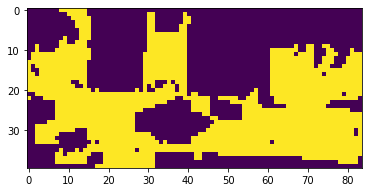

In [6]:

# # visualize the np array
# import matplotlib.pyplot as plt
# plt.imshow(grid>0)


In [7]:
# ones_indices = np.argwhere(grid>0)
# print(ones_indices)

[[ 0  8]
 [ 0  9]
 [ 0 10]
 ...
 [39 29]
 [39 30]
 [39 31]]


In [8]:
# # randomly select a start and end point
# start_point = tuple(ones_indices[np.random.randint(0, len(ones_indices))])
# end_point = tuple(ones_indices[np.random.randint(0, len(ones_indices))])

# def astar(grid, start_point, end_point):
#     """calculate the shortest path from start_point to end_point using A* algorithm

#     Args:
#         grid (_type_): a 2D numpy array representing the environment, 0 for obstacle, 1 for free space
#         start_point (_type_): _description_
#         end_point (_type_): _description_

#     Returns:
#         _type_: a list of points in the shortest path
#     """
#     def heuristic(a, b):
#         return abs(a[0] - b[0]) + abs(a[1] - b[1])

#     def get_neighbors(point):
#         neighbors = []
#         for i in range(-1, 2):
#             for j in range(-1, 2):
#                 if i == 0 and j == 0:
#                     continue
#                 x = point[0] + i
#                 y = point[1] + j
#                 if x >= 0 and x < grid.shape[0] and y >= 0 and y < grid.shape[1]:
#                     neighbors.append((x, y))
#         return neighbors

#     def get_path(came_from, current):
#         path = []
#         while current in came_from:
#             path.append(current)
#             current = came_from[current]
#         path.append(start_point)
#         return path[::-1]

#     open_set = set([start_point])
#     came_from = {}
#     g_score = {start_point: 0}
#     f_score = {start_point: heuristic(start_point, end_point)}

#     while open_set:
#         current = min(open_set, key=lambda x: f_score[x])
#         if current == end_point:
#             return get_path(came_from, current)

#         open_set.remove(current)
#         for neighbor in get_neighbors(current):
#             tentative_g_score = g_score[current] + 1
#             if grid[neighbor[0], neighbor[1]] == 0:
#                 continue
#             if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
#                 came_from[neighbor] = current
#                 g_score[neighbor] = tentative_g_score
#                 f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, end_point)
#                 if neighbor not in open_set:
#                     open_set.add(neighbor)

#     return None
    


# path = astar(grid, start_point, end_point)
# print(path)

[(2, 31), (3, 31), (4, 31), (5, 31), (6, 32), (7, 33), (8, 34), (9, 35), (10, 36), (11, 37), (12, 38), (13, 39), (14, 39), (15, 39), (16, 39), (17, 39), (18, 39), (19, 39), (20, 39), (21, 39), (22, 40), (23, 41), (24, 42), (25, 43), (26, 44), (26, 45), (27, 46), (28, 47), (29, 48), (30, 49), (31, 50), (32, 51), (33, 52), (34, 53), (34, 54), (34, 55), (34, 56), (34, 57), (34, 58), (34, 59), (34, 60), (34, 61), (34, 62), (34, 63), (34, 64), (34, 65)]


(40, 84)


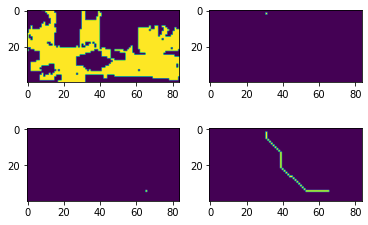

In [9]:
# path = np.array(path)

# path_grid = np.zeros_like(grid)
# path_grid[path[:, 0], path[:, 1]] = 1
# print(path_grid.shape)

# # start point and end point
# start_grid = np.zeros_like(grid)
# start_grid[start_point[0], start_point[1]] = 100
# end_grid = np.zeros_like(grid)
# end_grid[end_point[0], end_point[1]] = 100

# plt.subplot(2, 2, 1)
# plt.imshow(grid>0)
# plt.subplot(2, 2, 2)
# plt.imshow(start_grid>0)
# plt.subplot(2, 2, 3)
# plt.imshow(end_grid>0)
# plt.subplot(2, 2, 4)
# plt.imshow(path_grid>0)

In [10]:
# # convert path to world coordinates
# path_world = np.zeros((len(path), 3))
# path_world[:, 0] = path[:, 1] * voxel_size + min_bound[0]
# path_world[:, 1] = (grid_height - path[:, 0] - 1) * voxel_size + min_bound[1]
# path_world[:, 2] = 1

# # visualize the path in 3D
# path_pcd = o3d.geometry.PointCloud()
# path_pcd.points = o3d.utility.Vector3dVector(path_world)
# path_pcd.paint_uniform_color([0, 0, 1])
# o3d.visualization.draw_geometries([pcd, path_pcd])

[Open3D DEBUG] [Visualizer] Creating window.
[Open3D DEBUG] GLFW init.
[Open3D DEBUG] Add geometry and update bounding box to [(-0.1144, -0.0424, -0.0067) - (8.5827, 4.0843, 2.3774)]
[Open3D DEBUG] Add geometry and update bounding box to [(-0.1144, -0.0424, -0.0067) - (8.5827, 4.0843, 2.3774)]
[Open3D DEBUG] [Visualizer] Destroying window.
[Open3D DEBUG] GLFW destruct.


In [11]:
# torch.tensor(pcd.points).shape

In [12]:

# points_np = np.asarray(pcd.points)
# points_np.max(axis=0), points_np.min(axis=0)
# # Remove points with z axis less than 0.1 higher than the lowest point
# points_np = points_np[points_np[:, 2] > points_np.min(axis=0)[2] + 0.1]
# points_np.shape

In [13]:
# # convert points_np back to open3d point cloud and visualize
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(points_np)
# o3d.visualization.draw_geometries([pcd])

In [14]:
# # convert point cloud to voxel grid
# voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=0.1)

In [15]:
# # visualize voxel grid
# o3d.visualization.draw_geometries([voxel_grid])

In [16]:
# # number of voxels
# voxel_grid.get_max_bound(),voxel_grid.get_min_bound(), voxel_grid.get_max_bound() - voxel_grid.get_min_bound()

In [17]:
# # convert to voxel grid
# # print(voxel_grid.get_min_bound() + 2)
# voxel_grid_0 = o3d.geometry.VoxelGrid.create_from_point_cloud_within_bounds(pcd, voxel_size=0.1, min_bound=np.array([-0.11438844, -0.04241469, 1.00674985]), max_bound=np.array([8.63561156, 4.10758531, 2.44325015]))

In [18]:
# o3d.visualization.draw_geometries([voxel_grid_0])

In [19]:
# v0 = voxel_grid.get_voxels()[0]
# v0.grid_index, v0.color

In [20]:
# # convert voxel grid to a boolean numpy array
# voxel_grid_bool = np.zeros((32, 32, 32), dtype=bool)
# for voxel in voxel_grid.get_voxels():
#     voxel_grid_bool[voxel.grid_index] = True
    

In [21]:
# # shape of voxel grid
# len(voxel_grid.get_voxels())

In [22]:
# # choose a voxel and visualize it
# voxel = voxel_grid.get_voxels()[0]
# print(voxel)

In [23]:
# voxels = voxel_grid.get_voxels()  # returns list of voxels
# indices = np.stack(list(vx.grid_index for vx in voxels))
# colors = np.stack(list(vx.color for vx in voxels))
